In [ ]:
#default_exp data
from nbdev.showdoc import show_doc

In [ ]:
#hide 
import matplotlib.patches as patches
from scipy import ndimage
from deepflash2.utils import save_mask
import shutil

In [ ]:
#export
import os, zarr, cv2, imageio, shutil, random

import numpy as np

from matplotlib.patches import Rectangle
from skimage.measure import label
from skimage.color import label2rgb

import albumentations as A
import albumentations.augmentations.functional as AF
from albumentations.pytorch.transforms import ToTensorV2

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from fastai.vision.all import *
from fastcore.all import *
from fastprogress import progress_bar

# Data

> This module defines tools for image data preprocessing and real-time data augmentation that is used to train a model.

## Plot images and masks

In [ ]:
#export
def show(*obj, file_name=None, overlay=False, pred=False,
         show_bbox=True, figsize=(10,10), cmap='binary_r', **kwargs):
    "Show image, mask, and weight (optional)"
    if len(obj)==3:
        img,msk,weight = obj
    elif len(obj)==2:
        img,msk = obj
        weight = None
    elif len(obj)==1:
        img = obj[0]
        msk, weight = None, None
        
    else:
        raise ValueError(f'Function not defined for {len(obj)} arguments.')
    
    # Image preprocessing
    img = np.array(img)
    # Swap axis to channels last
    if img.shape[0]<20: img=np.moveaxis(img,0,-1)
    # One channel images
    if img.ndim == 3 and img.shape[-1] == 1: 
        img=img[...,0]

    # Mask preprocessing
    if msk is not None:
        msk = np.array(msk)
        # Remove background class from masks
        if msk.shape[0]==2: msk=msk[1,...]
        # Create bbox

        pad = (np.array(img.shape[:2])-np.array(msk.shape))//2
        bbox = Rectangle((pad[0]-1,pad[1]-1),img.shape[0]-2*pad[0]+1,img.shape[0]-2*pad[0]+1,
                 edgecolor='r',linewidth=1,facecolor='none')

        # Padding mask and weights
        msk = np.pad(msk, pad, 'constant', constant_values=(0))

        if cmap is None:
            cmap = 'binary_r' if msk.max()==1 else cmap
    
    # Weights preprocessing
    if weight is not None:
        weight = np.array(weight)
        weight = np.pad(weight, pad, 'constant', constant_values=(0))

    ncol=1 if msk is None else 2
    ncol=ncol if weight is None else ncol+1
    fig, ax = plt.subplots(1,ncol,figsize=figsize)
    img_ax = ax[0] if ncol>1 else ax
    
    # Plot img
    img_ax.imshow(img, cmap=cmap)
    if file_name is not None:
        img_ax.set_title('Image {}'.format(file_name))
    else:
        img_ax.set_title('Image')
    img_ax.set_axis_off()

    # Plot img and mask
    if msk is not None:
        if overlay:
            label_image = label(msk)
            img_l2o = label2rgb(label_image, image=img, bg_label=0, alpha=.8, image_alpha=1)
            ax[1].set_title('Image + Mask (#ROIs: {})'.format(label_image.max()))
            ax[1].imshow(img_l2o)
        else:
            ax[1].imshow(msk, cmap=cmap)
            ax[1].set_title('Mask')
        if show_bbox: ax[1].add_patch(copy(bbox))

        ax[1].set_axis_off()

    # Plot weights
    if weight is not None:
        max_w = weight.max()
        vmax_w = max(1, max_w)
        ax[2].imshow(weight, vmax=vmax_w, cmap=cmap)
        if pred:
            ax[2].set_title('Prediction')
        else:
            ax[2].set_title('Weights (max value: {:.{p}f})'.format(max_w, p=1))
        if show_bbox: ax[2].add_patch(copy(bbox))
        ax[2].set_axis_off()

    #ax.set_axis_off()
    plt.tight_layout()
    plt.show()

The show methods in fastai all rely on some types being able to show themselves. We create a new type with a show method.

#### Typedispatch

Custom `show_batch` and `show_results` for  `DataLoader`

In [ ]:
#export
@typedispatch
def show_batch(x:TensorImage, y:tuple, samples, max_n=6, figsize=None, **kwargs):
    "Show one batch (image, mask, and weights) from a `DataLoader`"
    max_n = np.min((max_n, len(x)))
    if figsize is None: figsize = (12, max_n * 5)
    for i in range(max_n): show(x[i], y[0][i], y[1][i], figsize=figsize, **kwargs)

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y:tuple, samples, outs, max_n=4, figsize=None, **kwargs):
    "Show image, mask, and weights from `max_n` items"
    max_n = np.min((max_n, len(x)))
    if figsize is None: figsize = (12, max_n * 5)
    for i in range(max_n): show(x[i], y[0][i], outs[i][0], pred=True, figsize=figsize, **kwargs)

__Example image and mask__

We will use an example image and mask to guide through the documentation.

In [ ]:
#hide
# Generate an initial random image and mask with two circles
np.random.seed(0)
x, y = np.indices((540, 540))
x1, y1, x2, y2 = 180, 180, 41*7, 52*7
r1, r2 = 10*7.20, 20*7
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
mask = np.logical_or(mask_circle1, mask_circle2).astype(int)
mask[:10,:] = 1
mask[-10:,:] = 1
mask[:,:10] = 1
mask[:,-10:] = 1
inst_labels, _ = ndimage.measurements.label(mask)
image = np.random.rand(*mask.shape)+mask*2.
path=Path('data_tmp')
(path/'images').mkdir(parents=True, exist_ok=True)
imageio.imsave(path/'images'/'01.png', image)
(path/'labels').mkdir(parents=True, exist_ok=True)
save_mask(mask, path/'labels'/'01_mask.png')

Lossy conversion from float64 to uint8. Range [2.9504162779581122e-06, 2.999983172350504]. Convert image to uint8 prior to saving to suppress this warning.


In [ ]:
#hide
def _show(*args, cmap = 'binary_r'):
    figsize=(3*len(args),6)
    fig, ax = plt.subplots(1, ncols=len(args),figsize=figsize, squeeze=False)
    for i,x in enumerate(args):
        ax[0,i].imshow(x, cmap=cmap)
        ax[0,i].set_axis_off()
    plt.tight_layout()
    plt.show()

Plot example image and mask

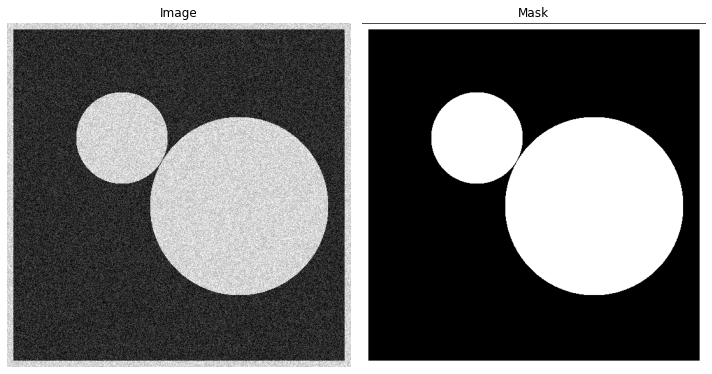

In [ ]:
image = imageio.imread(path/'images'/'01.png')
mask = imageio.imread(path/'labels'/'01_mask.png')
show(image, mask)

## Mask preprocessing

Supported segmentation mask types:

**Class labels**: pixel annotations of classes (e.g., 0 for background and 1...n for positive classes) <br>
**Instance labels**: pixel annotation of belonggig to different instance (e.g., 0 for background, 1 for first ROI, 2 for second ROI, etc.).

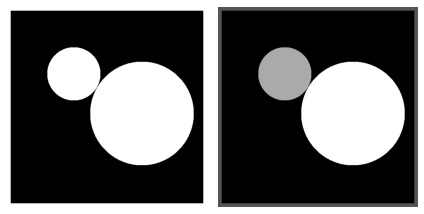

In [ ]:
_show(mask, inst_labels)

The provided segmentation masks are preprocessed to 
- convert instance labels to class labels
- draw small ridges between touching instances (optional)

In [ ]:
#export
# adapted from Falk, Thorsten, et al. "U-Net: deep learning for cell counting, detection, and morphometry." Nature methods 16.1 (2019): 67-70.
def preprocess_mask(clabels=None, instlabels=None, remove_connectivity=True, num_classes = 2):
    "Calculates the weights from the given mask (classlabels `clabels` or `instlabels`)."

    assert not (clabels is None and instlabels is None), "Provide either clabels or instlabels"

    # If no classlabels are given treat the problem as binary segmentation
    # ==> Create a new array assigning class 1 (foreground) to each instance
    if clabels is None:
        clabels = (instlabels[:] > 0).astype(int)
    else: clabels = np.array(clabels[:])

    if remove_connectivity:
        # Initialize label and weights arrays with background
        labels = np.zeros_like(clabels)
        classes = np.unique(clabels)[1:]
        # If no instance labels are given, generate them now
        if instlabels is None:
            # Creating instance labels from mask
            instlabels = np.zeros_like(clabels)
            nextInstance = 1
            for c in classes:
                #comps2, nInstances2 = ndimage.measurements.label(clabels == c)
                nInstances, comps = cv2.connectedComponents((clabels[:] == c).astype('uint8'), connectivity=4)
                nInstances -=1
                instlabels[comps > 0] = comps[comps > 0] + nextInstance
                nextInstance += nInstances

        for c in classes:
            # Extract all instance labels of class c
            il = (instlabels * (clabels[:] == c)).astype(np.int16)
            instances = np.unique(il)[1:]

            # Generate background ridges between touching instances
            # of that class, avoid overlapping instances
            dil = cv2.morphologyEx(il, cv2.MORPH_CLOSE, kernel=np.ones((3,) * num_classes))
            overlap_cand = np.unique(np.where(dil!=il, dil, 0))        
            labels[np.isin(il, overlap_cand, invert=True)] = c

            for instance in overlap_cand[1:]:
                objectMaskDil = cv2.dilate((labels == c).astype('uint8'), kernel=np.ones((3,) * num_classes),iterations = 1)
                labels[(instlabels == instance) & (objectMaskDil == 0)] = c
    else:
        labels = clabels        

    return labels#.astype(np.int32)

Arguments in `preprocess_masks`:
- `clabels`: class labels (segmentation mask), 
- `instlabels`: instance labels (segmentation mask), 
- `num_classes` (int) = number of classes

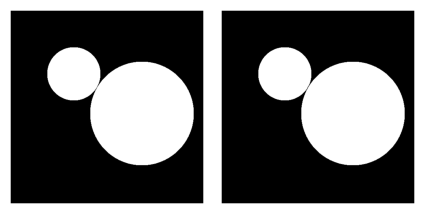

Zoom in on borders:


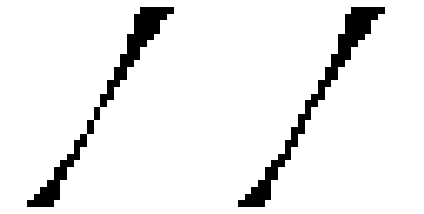

In [ ]:
tst1 = preprocess_mask(mask, remove_connectivity=False)
tst2 = preprocess_mask(mask, remove_connectivity=True)
_show(tst1,tst2)
ind = (slice(200,230), slice(230,260))
print('Zoom in on borders:')
_show(tst1[ind], tst2[ind])

## Data augmentation

Deformation field class to ensure that all augmentations are performed equally on images, masks, and weights. Implemented augmentations are
- rotation
- mirroring
- random deformation

In [ ]:
#export
# adapted from Falk, Thorsten, et al. "U-Net: deep learning for cell counting, detection, and morphometry." Nature methods 16.1 (2019): 67-70.
class DeformationField:
    "Creates a deformation field for data augmentation"
    def __init__(self, shape=(540, 540), scale=1, scale_range=(0,0), p_scale=1.):
        self.shape = shape
        self.default_scale = self.scale = scale
        
        if random.random()<p_scale and sum(scale_range)!=0: 
            self.scale = random.uniform(*np.array(scale_range)*scale)
        
        grid_range = [np.linspace(-(d*self.scale)/2, ((d*self.scale)/2)-1, d) for d in shape] 
        self.deformationField = np.meshgrid(*grid_range)[::-1]

    def rotate(self, theta=0):
        "Rotate deformation field"
        self.deformationField = [
                self.deformationField[0] * np.cos(theta)
                + self.deformationField[1] * np.sin(theta),
                -self.deformationField[0] * np.sin(theta)
                + self.deformationField[1] * np.cos(theta),
            ]

    def add_random_rotation(self, rotation_range_deg, p=0.5):
        'Add random rotation'
        if (random.random() < p):
            self.rotate(
                    theta=np.pi * (random.random()
                                * (rotation_range_deg[1] - rotation_range_deg[0])
                                +  rotation_range_deg[0])
                                / 180.0)
        
    def mirror(self, dims):
        "Mirror deformation fild at dims"
        for d in range(len(self.shape)):
            if dims[d]:
                self.deformationField[d] = -self.deformationField[d]

    def add_random_flip(self, p=0.5):
        "Add random flip"
        if (random.random() < p):
            self.mirror(np.random.choice((True,False),2))    
    
    def get(self, offset=(0, 0), pad=(0, 0)):
        "Get relevant slice from deformation field"
        sliceDef = tuple(slice(int(p / 2), int(-p / 2)) if p > 0 else None for p in pad)
        deform = [d[sliceDef] for d in self.deformationField]
        return [d + offs for (d, offs) in zip(deform, offset)]

    
    def apply(self, data, offset=(0, 0), pad=(0, 0), order=1):
        "Apply deformation field to image using interpolation"
              
        outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
        coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
        
        # Get slices to avoid loading all data (.zarr files)
        sl = []
        for i in range(len(coords)):
            cmin, cmax = int(coords[i].min()), int(coords[i].max())
            dmax = data.shape[i]
            if cmin<0: 
                cmax = max(-cmin, cmax)
                cmin = 0 
            elif cmax>dmax:
                cmin = min(cmin, 2*dmax-cmax)
                cmax = dmax
                coords[i] -= cmin
            else: coords[i] -= cmin
            sl.append(slice(cmin, cmax)) 
            
            
        remap_fn = A.augmentations.functional._maybe_process_in_chunks(
            cv2.remap, map1=coords[1],map2=coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT
        )
        return remap_fn(data[tuple(sl)])

Original Image

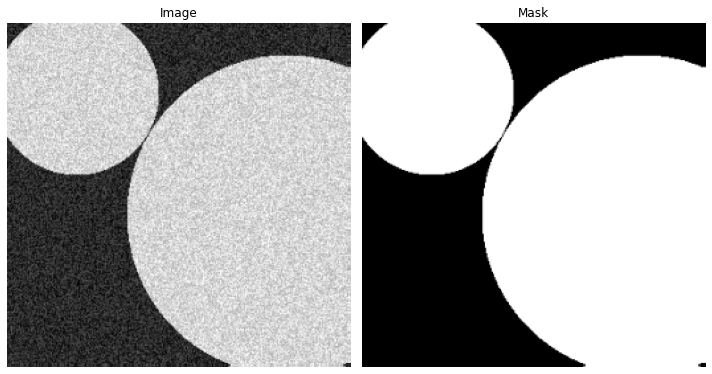

In [ ]:
tst = DeformationField(shape=(260, 260), scale=1, scale_range=(0.7, 1.4))
show(tst.apply(image, offset=(270,270)), 
     tst.apply(mask, offset=(270,270)))

Add mirroring

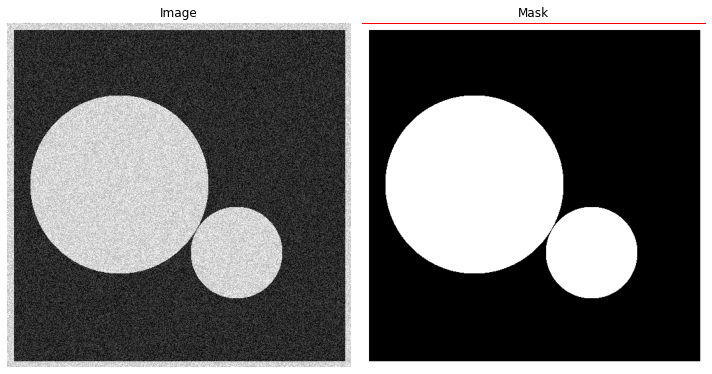

In [ ]:
tst = DeformationField()
tst.mirror((1,1))
show(tst.apply(image, offset=(270,270)), 
     tst.apply(mask, offset=(270,270)))

Add rotation

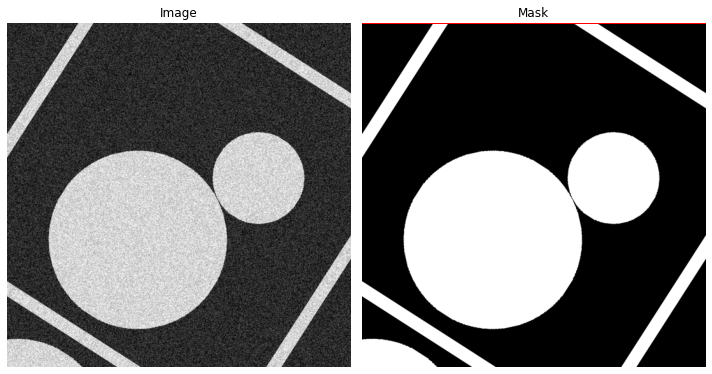

In [ ]:
tst.rotate(1)
show(tst.apply(image, offset=(270,270)), 
     tst.apply(mask, offset=(270,270)))

## Datasets

Pytorch map-style [datasets](https://pytorch.org/docs/stable/data.html) for training and validation.

### Helper functions

In [ ]:
#export
def _read_img(path, **kwargs):
    "Read image"
    if path.suffix == '.zarr':
        img = zarr.convenience.open(path.as_posix()) 
    else:
        img = imageio.imread(path, **kwargs)
        #if img.max()>1.:
        #    img = img/np.iinfo(img.dtype).max
        if img.ndim == 2:
            img = np.expand_dims(img, axis=2)
    return img

In [ ]:
#export
def _read_msk(path, num_classes=2, instance_labels=False, remove_connectivity=True, **kwargs):
    "Read image and check classes"
    if path.suffix == '.zarr':
        msk = zarr.convenience.open(path.as_posix()) 
    else: 
        msk = imageio.imread(path, **kwargs)
    if instance_labels:
        msk = preprocess_mask(clabels=None, instlabels=msk, remove_connectivity=remove_connectivity, num_classes=num_classes)
    else:
        # handle binary labels that are scaled different from 0 and 1
        if num_classes==2 and np.max(msk)>1 and len(np.unique(msk))==2:
            msk = msk//np.max(msk)
        # Remove channels if no extra information given
        if len(msk.shape)==3:
            if np.array_equal(msk[...,0], msk[...,1]):
                msk = msk[...,0]
        # Mask check
    assert len(np.unique(msk))<=num_classes, f'Expected mask with {num_classes} classes but got mask with {len(np.unique(msk))} classes {np.unique(msk)} . Are you using instance labels?' 
    assert len(msk.shape)==2, 'Currently, only masks with a single channel are supported.'
    return msk.astype('uint8')

In [ ]:
#tests
path_test = path/'mask.png'
for num_classes in [2,3,10]:
    x1 = np.random.randint(num_classes, size=(512, 512))
    save_mask(x1, path_test)
    x2 = _read_msk(path_test, num_classes=num_classes)
    test_eq(x1, x2)
    path_test.unlink()

### Base Class

In [ ]:
#export
def tiles_in_rectangles(H, W, h, w):
    '''Get smaller rectangles needed to fill the larger rectangle'''
 
    n_H = math.ceil(float(H)/float(h))
    n_W = math.ceil(float(W)/float(w))
         
    return n_H*n_W

In [ ]:
#export
class BaseDataset(Dataset):
    def __init__(self, files, label_fn=None, instance_labels = False, num_classes=2, ignore={},remove_connectivity=True,
                 stats=None,normalize=True, use_zarr_data=True,
                 tile_shape=(512,512), padding=(0,0),preproc_dir=None, verbose=1, scale=1, pdf_reshape=512, use_preprocessed_labels=False, **kwargs):
        store_attr('files, label_fn, instance_labels, num_classes, ignore, tile_shape, remove_connectivity, padding, preproc_dir, stats, normalize, scale, pdf_reshape, use_preprocessed_labels')
        self.c = num_classes
        self.use_zarr_data=False
        
        if self.stats is None:
            self.mean_sum, self.var_sum = 0., 0.
            self.max_tile_count = 0
            self.actual_tile_shape = (np.array(self.tile_shape)-np.array(self.padding))
        
        if label_fn is not None:   
            self.preproc_dir = self.preproc_dir or zarr.storage.TempStore()
            root = zarr.group(store=self.preproc_dir, overwrite= not use_preprocessed_labels)
            self.data, self.labels, self.pdfs  = root.require_groups('data', 'labels','pdfs')
            self._preproc(use_zarr_data=use_zarr_data, verbose=verbose)
                
    def read_img(self, path, **kwargs):
        if self.use_zarr_data: img = self.data[path.name]
        else: img = _read_img(path, **kwargs)
        return img
        
    def read_mask(self, *args, **kwargs):
        return _read_msk(*args, **kwargs)
    
    def _create_cdf(self, mask, ignore, sampling_weights=None, igonore_edges_pct=0):
        'Creates a cumulated probability density function (CDF) for weighted sampling '

        # Create mask
        mask = mask[:]
        
        if sampling_weights is None:
            classes, counts = np.unique(mask, return_counts=True)
            sampling_weights = {k:1-v/mask.size for k,v in zip(classes, counts)}
        
        # Set pixel weights
        pdf = np.zeros_like(mask, dtype=np.float32)
        for k, v in sampling_weights.items():
            pdf[mask==k] = v
            
        
        # Set weight and sampling probability for ignored regions to 0
        if ignore is not None:
            pdf[ignore[:]] = 0
        
        if igonore_edges_pct>0:
            w = int(self.tile_shape[0]*igonore_edges_pct/2) #0.25
            pdf[:, :w] = pdf[:, -w:] = 0
            pdf[:w, :] = pdf[-w:, :] = 0

        # Reshape
        reshape_w = int((pdf.shape[1]/pdf.shape[0])*self.pdf_reshape)
        pdf = cv2.resize(pdf, dsize=(reshape_w, self.pdf_reshape))
        
        # Normalize pixel weights
        pdf /= pdf.sum()

        return np.cumsum(pdf/np.sum(pdf))
    
    def _preproc_file(self, file, use_zarr_data=True):
        "Preprocesses and saves images, labels (msk), weights, and pdf."
        
        # Load and save image
        img = self.read_img(file)
        
        if self.stats is None:
            self.mean_sum += img.mean((0,1))
            self.var_sum += img.var((0,1))
            self.max_tile_count = max(self.max_tile_count, tiles_in_rectangles(*img.shape[:2], *self.actual_tile_shape))
        if use_zarr_data: self.data[file.name] = img
        
        if self.label_fn is not None:
            # Load and save image
            label_path = self.label_fn(file)
            ign = self.ignore[file.name] if file.name in self.ignore else None
            lbl = self.read_mask(label_path,  num_classes=self.c, instance_labels=self.instance_labels, remove_connectivity=self.remove_connectivity)
            self.labels[file.name] = lbl
            self.pdfs[file.name] = self._create_cdf(lbl, ignore=ign)
        
    def _preproc(self, use_zarr_data=True, verbose=0):
        using_cache = False
        if verbose>0: print('Preprocessing data')
        for f in progress_bar(self.files, leave=True if verbose>0 else False):
            if self.use_preprocessed_labels:
                try:
                    self.data[f.name]
                    if self.label_fn is not None:
                        self.labels[f.name]
                        self.pdfs[f.name]
                        if not using_cache:
                            #if verbose>0: print(f'Using preprocessed data from {self.preproc_dir}')
                            using_cache = True
                except:
                    self._preproc_file(f, use_zarr_data=use_zarr_data)  
            else:
                self._preproc_file(f, use_zarr_data=use_zarr_data)
        
        self.use_zarr_data=use_zarr_data
        
        if self.stats is None:
            n = len(self.files)
             #https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch/60803379#60803379
            self.stats = {'channel_means': self.mean_sum/n, 
                          'channel_stds': np.sqrt(self.var_sum/n), 
                          'max_tiles_per_image': self.max_tile_count}
            print('Calculated stats', self.stats)
    
    def get_data(self, files=None, max_n=None, mask=False):
        if files is not None:
            files = L(files)
        elif max_n is not None:
            max_n = np.min((max_n, len(self.files)))
            files = self.files[:max_n]
        else: 
            files = self.files
        data_list = L()
        for f in files:
            if mask: d = self.labels[f.name]
            else: d = self.read_img(f)
            data_list.append(d)
        return data_list
      
    def show_data(self, files=None, max_n=6, ncols=1, figsize=None, **kwargs):
        if files is not None:
            files = L(files)
            max_n = len(files)
        else:
            max_n = np.min((max_n, len(self.files)))
            files = self.files[:max_n]
        if figsize is None: figsize = (ncols*12, max_n//ncols * 5)
        for f in files:
            img = self.read_img(f)
            if self.label_fn is not None:
                lbl = self.labels[f.name]
                show(img, lbl, file_name=f.name, figsize=figsize, show_bbox=False, **kwargs)
            else:
                show(img, file_name=f.name, figsize=figsize, show_bbox=False, **kwargs)

Preprocessing data


Calculated stats {'channel_means': array([100.18701303]), 'channel_stds': array([84.32689916]), 'max_tiles_per_image': 4}


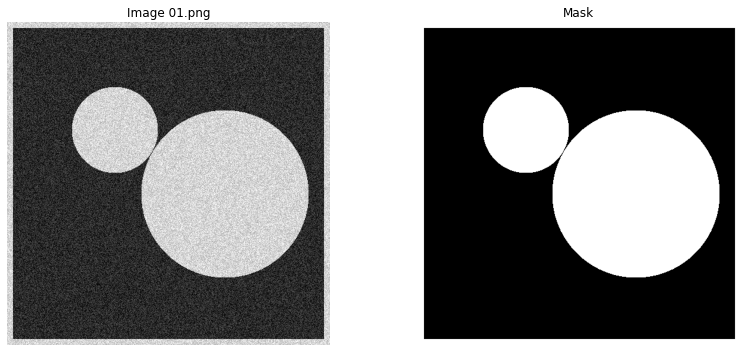

In [ ]:
files = get_image_files(path/'images')
label_fn = label_fn = lambda o: path/'labels'/f'{o.stem}_mask.png'#lambda o: path/'labels'/f'{o.stem}_mask{o.suffix}'
tst = BaseDataset(files, label_fn=label_fn, num_classes=2)
tst.show_data()

### RandomTileDataset

For training

In [ ]:
#export
class RandomTileDataset(BaseDataset):
    """
    Pytorch Dataset that creates random tiles with augmentations from the input images.
    """
    n_inp = 1
    def __init__(self, *args, sample_mult=None, flip=True, rotation_range_deg=(0, 360), scale_range=(0, 0), 
                 albumentations_tfms=[A.RandomGamma()], min_length=400, **kwargs): 
        super().__init__(*args, **kwargs) 
        store_attr('sample_mult, flip, rotation_range_deg, scale_range, albumentations_tfms')

        # Sample mulutiplier: Number of random samplings from augmented image
        if self.sample_mult is None:
            #msk_shape = np.array(lbl.shape[-2:])
            #sample_mult = int(np.product(np.floor(msk_shape/tile_shape)))
            self.sample_mult = max(int(self.stats['max_tiles_per_image']/self.scale**2),
                                   min_length//len(self.files))
            
        tfms = self.albumentations_tfms
        if self.normalize: 
            tfms += [
                A.Normalize(mean=self.stats['channel_means'], 
                            std=self.stats['channel_stds'], 
                            max_pixel_value=1.0)
            ]
        self.tfms =  A.Compose(tfms+[ToTensorV2()])

    def _random_center(self, pdf, orig_shape, reshape=512):
        'Sample random center using PDF'
        reshape_y = int((orig_shape[1]/orig_shape[0])*reshape)
        cx, cy = np.unravel_index(np.argmax(pdf > random.random()), (reshape,reshape_y))
        cx = int(cx*orig_shape[0]/reshape)
        cy = int(cy*orig_shape[1]/reshape_y)
        return cx, cy
    
    def __len__(self):
        return len(self.files)*self.sample_mult

    def __getitem__(self, idx):
        idx = idx % len(self.files)
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.files[idx]
        img = self.read_img(img_path)

        msk = self.labels[img_path.name]
        pdf = self.pdfs[img_path.name] 
        center = self._random_center(pdf[:], msk.shape)

        deformationField = DeformationField(self.tile_shape, self.scale, self.scale_range)
        if self.flip:
            deformationField.add_random_flip(self.flip)
        
        if self.rotation_range_deg[1] > self.rotation_range_deg[0]:
            deformationField.add_random_rotation(self.rotation_range_deg)
        
        img = deformationField.apply(img, center)
        msk = deformationField.apply(msk, center)
            
        aug = self.tfms(image=img, mask=msk)

        return  aug['image'], aug['mask'].type(torch.int64)

    
Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            tile_shape - The tile shape the network expects as input
            padding - The padding (input shape - output shape)
            classlabels - A list containing the corresponding class labels.
                          0 = ignore, 1 = background, 2-n foreground classes
                          If None, the problem will be treated as binary segmentation
            num_classes - The number of classes including background
            ignore - A list containing the corresponding ignore regions.
            weights - A list containing the corresponding weights.
            element_size_um - The target pixel size in micrometers
            batch_size - The number of tiles to generate per batch
            rotation_range_deg - (alpha_min, alpha_max): The range of rotation angles.
                                 A random rotation is drawn from a uniform distribution
                                 in the given range
            flip - If true, a coin flip decides whether a mirrored tile will be
                   generated
            deformation_grid - (dx, dy): The distance of neighboring grid points in
                               pixels for which random deformation vectors are drawn
            deformation_magnitude - (sx, sy): The standard deviations of the
                                    Gaussians, the components of the deformation
                                    vector are drawn from
            value_minimum_range - (v_min, v_max): Input intensity zero will be mapped
                                  to a random value in the given range
            value_maximum_range - (v_min, v_max): Input intensity one will be mapped
                                  to a random value within the given range
            value_slope_range - (s_min, s_max): The slope at control points is drawn
                                from a uniform distribution in the given range

Show data

Preprocessing data


Calculated stats {'channel_means': array([100.18701303]), 'channel_stds': array([84.32689916]), 'max_tiles_per_image': 4}


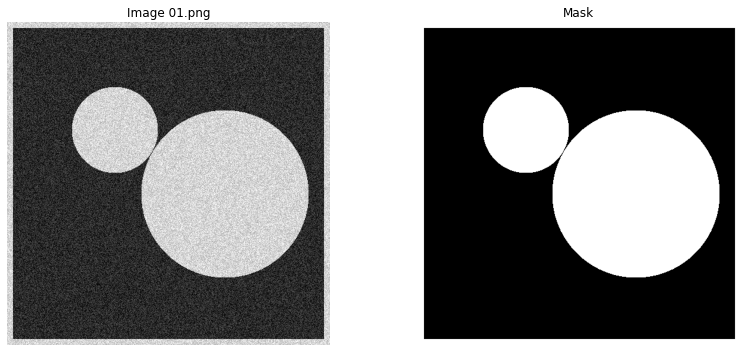

In [ ]:
tst = RandomTileDataset(files, label_fn=label_fn, verbose=2, scale=1, num_classes=2)#, albumentations_tfms=get_aug())
tst.show_data()

Show random tile

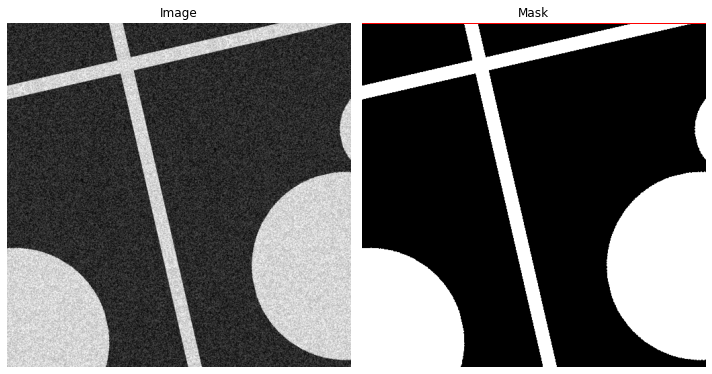

In [ ]:
tile = tst[0]
show(tile[0], tile[1])

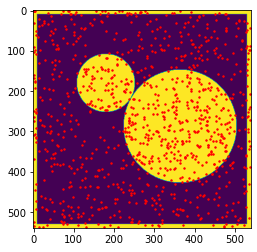

In [ ]:
img_path = tst.files[0]
cdf = tst.pdfs[img_path.name][:] 
centers = [tst._random_center(cdf, mask.shape) for _ in range(int(1e+3))]
plt.imshow(mask)
xs = [x[1] for x in centers]
ys = [x[0] for x in centers]
plt.scatter(x=xs, y=ys, c='r', s=2)
plt.show()

### TileDataset

In [ ]:
#export
class TileDataset(BaseDataset):
    "Pytorch Dataset that creates random tiles for validation and prediction on new data."
    n_inp = 1
    def __init__(self, *args, val_length=None, val_seed=42, max_tile_shift=1., border_padding_factor=0.25, return_index=False, **kwargs):
        super().__init__(*args, **kwargs)     
        self.max_tile_shift = max_tile_shift
        self.bpf = border_padding_factor
        self.return_index = return_index
        self.output_shape = tuple(int(t - p) for (t, p) in zip(self.tile_shape, self.padding))
        self.tiler = DeformationField(self.tile_shape, scale=self.scale)
        self.image_indices = []
        self.image_shapes = []
        self.in_slices = []
        self.out_slices = []
        self.centers = []
        self.valid_indices = None
        
        tfms = []
        if self.normalize: 
            tfms += [
                A.Normalize(mean=self.stats['channel_means'], 
                            std=self.stats['channel_stds'], 
                            max_pixel_value=1.0)
            ]
        self.tfms =  A.Compose(tfms+[ToTensorV2()])


        j = 0
        for i, file in enumerate(progress_bar(self.files, leave=False)):
            img = self.read_img(file)
            # Tiling
            data_shape = tuple(int(x//self.scale) for x in img.shape[:-1])
            start_points = [o//2 - o*self.bpf for o in self.output_shape]
            end_points = [(s - st) for s, st in zip(data_shape, start_points)]     
            n_points = [int((s+2*o*self.bpf)//(o*self.max_tile_shift))+1 for s, o in zip(data_shape, self.output_shape)]
            center_points = [np.linspace(st, e, num=n, endpoint=True, dtype=np.int64) for st, e, n in zip(start_points, end_points, n_points)]
            for cx in center_points[1]:
                for cy in center_points[0]:
                    self.centers.append((int(cy*self.scale), int(cx*self.scale)))
                    self.image_indices.append(i)
                    self.image_shapes.append(data_shape)
                    
                    # Calculate output slices for whole image
                    out_slice = tuple(slice(int((c - o/2).clip(0, s)), int((c + o/2).clip(max=s)))
                                     for (c, o, s) in zip((cy, cx), self.output_shape, data_shape))
                    self.out_slices.append(out_slice)
                    
                    # Calculate input slices for tile
                    in_slice = tuple(slice(int((o/2-c).clip(0)), int(np.float64(o).clip(max=(s-c+o/2)))) for
                                     (c, o, s) in zip((cy, cx), self.output_shape, data_shape))
                    self.in_slices.append(in_slice)
                    #assert img[in_slice].shape == img[out_slice].shape, 'Input/Output slices do not match'
                    assert (in_slice[0].stop-in_slice[0].start) == (out_slice[0].stop-out_slice[0].start), 'Input/Output slices do not match'
                    assert (in_slice[1].stop-in_slice[1].start) == (out_slice[1].stop-out_slice[1].start), 'Input/Output slices do not match'
                    j += 1

        if val_length:
            if val_length>len(self.image_shapes):
                print(f'Reducing validation from lenght {val_length} to {len(self.image_shapes)}')
                val_length = len(self.image_shapes)
            rs = np.random.RandomState(val_seed)
            choice = rs.choice(len(self.image_indices), val_length, replace=False)
            self.valid_indices = {i:idx for i, idx in  enumerate(choice)}
            
    def __len__(self):
        if self.valid_indices: return len(self.valid_indices)
        else: return len(self.image_shapes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.valid_indices: idx = self.valid_indices[idx]
        img_path = self.files[self.image_indices[idx]]
        #img = self.data[img_path.name]
        img = self.read_img(img_path)
        centerPos = self.centers[idx]
        
        img = self.tiler.apply(img, centerPos)
        aug = self.tfms(image=img)
        
        if self.label_fn is not None:
            msk = self.labels[img_path.name]
            msk = self.tiler.apply(msk, centerPos).astype('int64')
            return  aug['image'], msk
        
        else:
            if self.return_index:
                return aug['image'], idx
            else:
                return aug['image']

    def get_tile_info(self, idx):
        'Returns dict containing information for image reconstruction'
        
        return {
            'out_idx' : self.image_indices[idx],
            'out_name' : self.files[self.image_indices[idx]].name,        
            'out_shape' : self.image_shapes[idx],
            'out_slice' : self.out_slices[idx],
            'in_slice' : self.in_slices[idx]
        }

Show data

Preprocessing data


Calculated stats {'channel_means': array([100.18701303]), 'channel_stds': array([84.32689916]), 'max_tiles_per_image': 9}


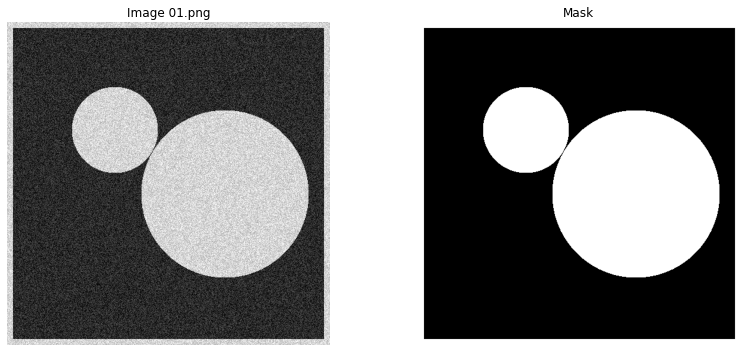

In [ ]:
tst = TileDataset(files, label_fn=label_fn, num_classes=2, tile_shape=(224,224), padding=(0,0), scale=1., val_length=6)
tst.show_data()

Show tiles on image
- Center points are indicated with red dots

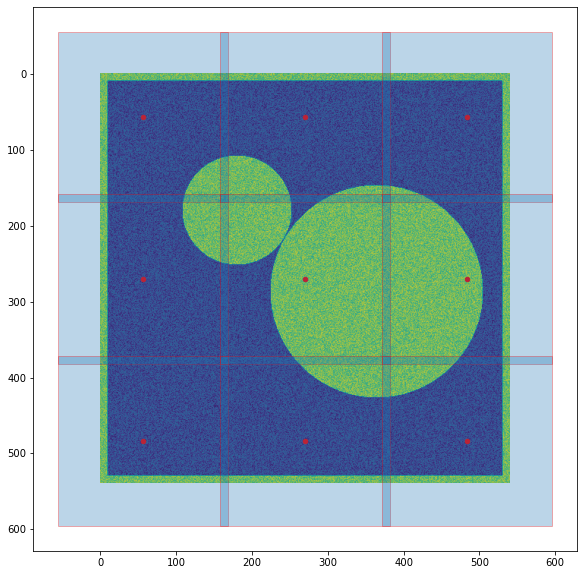

In [ ]:
fix, axs = plt.subplots(figsize=(10,10))
axs.imshow(ndimage.zoom(tst.get_data(max_n=1)[0][...,0], 1/tst.scale))
xs = [x[1]/tst.scale for x in tst.centers]
ys = [x[0]/tst.scale for x in tst.centers]
axs.scatter(x=xs, y=ys, c='r', s=20)
for xsi, ysi in zip(xs, ys):
    o = tst.output_shape
    rect = patches.Rectangle((xsi-o[0]/2,ysi-o[1]/2), o[0], o[1], linewidth=1, edgecolor='r', alpha=0.3)
    axs.add_patch(rect)
plt.show()

In [ ]:
shutil.rmtree(path)

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_config.ipynb.
Converted 01_models.ipynb.
Converted 02_data.ipynb.
Converted 03_learner.ipynb.
Converted 04_inference.ipynb.
Converted 05_losses.ipynb.
Converted 06_utils.ipynb.
Converted 07_tta.ipynb.
Converted 08_gui.ipynb.
Converted 09_gt.ipynb.
Converted add_information.ipynb.
Converted index.ipynb.
Converted model_library.ipynb.
Converted tutorial.ipynb.
Converted tutorial_gt.ipynb.
Converted tutorial_pred.ipynb.
Converted tutorial_train.ipynb.
